In [1]:

import numpy as np
import matplotlib.pyplot as plt
import skimage.io as skio
import h5py

from matplotlib.colors import LogNorm


In [2]:
from scipy.sparse import csr_matrix

def convert_sparse(a):
    output = np.zeros(shape=(3, a.size), dtype=np.uint32)
    # index
    output[0] = ((a >> 16) & (2 ** 21 - 1)).astype(np.uint32)
    # frame
    output[1] = (a >> 40).astype(np.uint32)
    # count
    output[2] = (a & (2 ** 12 - 1)).astype(np.uint8)
    return output


def read_rigaku_dataset(fname):
    with open(fname, 'r') as f:
        a = np.fromfile(f, dtype=np.uint64)
        d = convert_sparse(a)
        index, frame, count = d[0], d[1], d[2]
    num_frames = frame[-1] + 1
    dset = csr_matrix((count, (frame, index)), shape=(num_frames, 512 * 1024))
    return dset


In [3]:

data_root = '/home/8ididata/2021-2/babnigg202107_2/'
data_folder = 'B039_VPAVG_H02_500C10p_att00_Rq0/B039_VPAVG_H02_500C10p_att00_Rq0_02700'
data_name = '/B039_VPAVG_H02_500C10p_att00_Rq0_02700.bin'

dset = read_rigaku_dataset(data_root+data_folder+data_name)
dset_sum = np.array(dset.sum(axis=0))


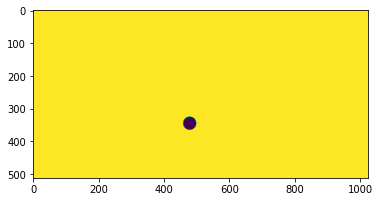

In [4]:
with h5py.File('./babnigg202107_2_qmap_Fig1_BSonly.h5') as f:
    mask = f['/data/mask'][()]
plt.imshow(mask)

# with h5py.File('qmap_for_mask') as f:
#     mask = f['/data/mask'][()]
# plt.imshow(mask)

/tmp/ipykernel_3059532/103959986.py:13: RuntimeWarning: divide by zero encountered in log10
  im = ax.imshow(np.log10(det_img[cen_x-width_x:cen_x+width_x,cen_y-width_y:cen_y+width_y]),


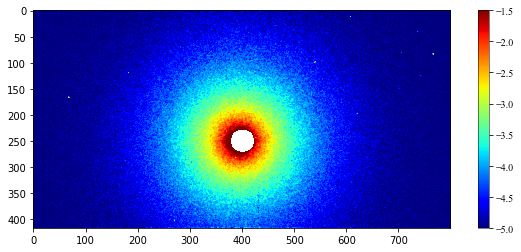

In [5]:

tmp = dset_sum.reshape(512, 1024)/100000
tmp[np.where(tmp==0)]=1e-5
det_img = tmp*mask

cen_x = 345 # vertical center
cen_y = 478 # horizontal center
width_x = 250 # vertical width
width_y = 400 # horizontal width

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['axes.linewidth'] = 0.5
im = ax.imshow(np.log10(det_img[cen_x-width_x:cen_x+width_x,cen_y-width_y:cen_y+width_y]),
               cmap='jet', vmin=-5, vmax=-1.5)
fig.colorbar(im, ax=ax)
plt.savefig('Averaged_SAXS.pdf', dpi=1200)



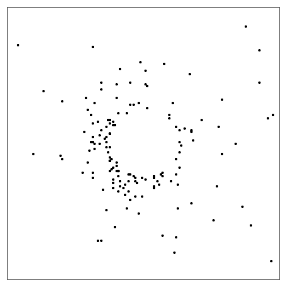

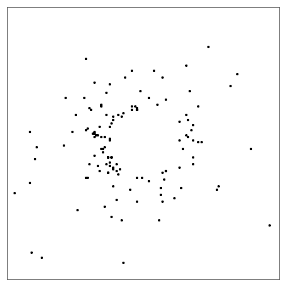

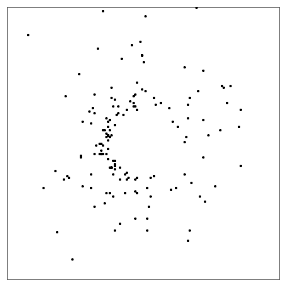

In [6]:


width_x_zoom = 80
width_y_zoom = 80

for n in range(3):
    x = np.array(dset[n].todense().reshape(512, 1024)) * mask
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    ax.imshow(x[cen_x-width_x_zoom:cen_x+width_x_zoom,
              cen_y-width_y_zoom:cen_y+width_y_zoom], 
              vmin=0, vmax=0.5, cmap=plt.cm.gray_r)
    plt.tick_params(left = False, right = False , labelleft = False , 
                labelbottom = False, bottom = False) 
    ax.get_figure().savefig(f"Single_Frame_{n+1:03d}.pdf")
